#### **Task 3**: Does the weather affect the delay? 
Use the API to pull the weather information for flights. There is no need to get weather for ALL flights. We can choose the right representative sample. Let's focus on four weather types:
- sunny
- cloudy
- rainy
- snow.

Test the hypothesis that these 4 delays are from the same distribution. If they are not, which ones are significantly different?

In [5]:
import pandas as pd
import numpy as np

In [21]:
flights = pd.read_pickle('flights.pkl')

In [24]:
flights.shape

(15927485, 42)

In [7]:
# select 1000 random rows to compare to weather 
flights_sample = flights.sample(n=1000)

# split table in to 5 dataframes (API allows only 250 requests per day)
# once each is populated with weather data, put back into main index for analysis on delays
flights1 = flights_sample.iloc[:200]
flights2 = flights_sample.iloc[201:400]
flights3 = flights_sample.iloc[401:600]
flights4 = flights_sample.iloc[601:800]
flights5 = flights_sample.iloc[801:1000]

## Create API request

In [8]:
import requests as re
import os
import json
from requests.auth import HTTPBasicAuth
from getpass import getpass

In [10]:
date = flights1.iloc[100]['fl_date']
city = flights1.iloc[100]['origin_city_name']
state = flights1.iloc[100]['origin_state'].lstrip()
API_KEY = os.getenv('VC_API')

#define URL to pull data from

url = ("https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/weatherdata/history"
        "?&aggregateHours=24"
        "&startDateTime={1}T00:00:00"
        "&endDateTime={1}T00:00:00"
        "&unitGroup=metric"
        "&contentType=json"
        "&dayStartTime=0:0:00"
        "&dayEndTime=0:0:00"
        "&location={2},{3},US"
        "&key={0}"
      .format(API_KEY, date, city, state))

       

In [13]:
resp = re.get(url)

data = resp.json()

resp.status_code

200

In [14]:
# get applicable data from json
data['locations'][f'{city},{state},US']['values'][0]['conditions']

'Snow, Partially cloudy'

In [15]:
# write function to add columns to dataframe with weather type

def weather(date, city, state):
    API_KEY = os.getenv('VC_API')
    url = ("https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/weatherdata/history"
        "?&aggregateHours=24"
        "&startDateTime={1}T00:00:00"
        "&endDateTime={1}T00:00:00"
        "&unitGroup=metric"
        "&contentType=json"
        "&dayStartTime=0:0:00"
        "&dayEndTime=0:0:00"
        "&location={2},{3},US"
        "&key={0}"
      .format(API_KEY, date, city, state))
    
    resp = re.get(url)
    data = resp.json()
    
    return data['locations'][f'{city},{state},US']['values'][0]['conditions']
    

In [16]:
# update with new flights dataset each day
test = flights1.iloc[:200]


In [17]:
origin_weather = []
dest_weather = []
for row in range(test.shape[0]):
    origin_weather.append(weather(test.iloc[row]['fl_date'],test.iloc[row]['origin_city_name'],test.iloc[row]['origin_state'].lstrip()))
    

In [25]:
origin_weather_df = pd.DataFrame(origin_weather, columns=['origin_weather'])

# update to weather-n with next iteration
weather1 = pd.concat([test.reset_index(),origin_weather_df],axis=1)

In [36]:
# update to weather-n with next iteration
weather1 = weather1.rename(columns={'Unnamed: 0': 'original_index'})
weather1 = weather1[['original_index','origin_weather']]


In [33]:
#concatenate weather iterations together
weather = pd.concat(['weather1','weather2','weather3','weather4'],ignore_index=True)

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name
0,2018-09-30,WN,WN,WN,6696,WN,N8577Z,6696,11292,DEN,...,1558,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-09-30,WN,WN,WN,103,WN,N8518R,103,11292,DEN,...,602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-09-30,WN,WN,WN,2908,WN,N499WN,2908,11292,DEN,...,602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-09-30,WN,WN,WN,3216,WN,N8669B,3216,11292,DEN,...,602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-09-30,WN,WN,WN,3705,WN,N8329B,3705,11292,DEN,...,602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
flights_weather = pd.merge(flights,weather1,left_index=True, right_on='original_index', how='right')

In [38]:
flights_weather

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name,original_index,origin_weather
0,2018-11-01,DL,DL_CODESHARE,DL,3493,9E,N928XJ,3493,11042,CLE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6124975,"Rain, Partially cloudy"
1,2019-04-10,B6,B6,B6,515,B6,N247JB,515,10721,BOS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2268286,"Rain, Partially cloudy"
2,2019-04-15,WN,WN,WN,729,WN,N258WN,729,13495,MSY,...,0.0,0.0,0.0,17.0,NaN,NaN,NaN,NaN,2363774,"Rain, Overcast"
3,2018-01-31,UA,UA,UA,1722,UA,N87531,1722,13930,ORD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4720380,Partially cloudy
4,2019-04-24,DL,DL,DL,1830,DL,N304DN,1830,12953,LGA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2578429,"Rain, Overcast"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2019-05-03,AA,AA,AA,402,AA,N926NN,402,11298,DFW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1409662,Partially cloudy
196,2018-04-22,AA,AA_CODESHARE,AA,5798,YV,N911FJ,5798,11540,ELP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,469972,Clear
197,2018-08-10,AA,AA_CODESHARE,AA,6056,CP,N213NN,6056,14057,PDX,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4946971,Overcast
198,2018-07-05,WN,WN,WN,643,WN,N8647A,643,11292,DEN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,736507,Partially cloudy


In [39]:
flights_weather.origin_weather.unique()

array(['Rain, Partially cloudy', 'Rain, Overcast', 'Partially cloudy',
       'Clear', '', 'Snow, Clear', 'Overcast', 'Rain, Clear',
       'Snow, Partially cloudy', 'Snow, Overcast'], dtype=object)

In [49]:
weather_dict = {'Rain, Partially cloudy':'Rain', 'Rain, Overcast':'Rain', 'Partially cloudy':'Cloudy',
       'Clear':'Sunny', '':'Sunny', 'Snow, Clear':'Snow', 'Overcast':'Cloudy', 'Rain, Clear':'Rain',
       'Snow, Partially cloudy':'Snow', 'Snow, Overcast':'Snow'}

In [60]:
flights_weather = flights_weather.replace(weather_dict)

In [61]:
flights_weather.groupby(['origin_weather'],as_index=False)['dep_delay'].mean()

,origin_weather,dep_delay
0,Cloudy,14.684932
1,Rain,10.134328
2,Snow,9.166667
3,Sunny,26.905660


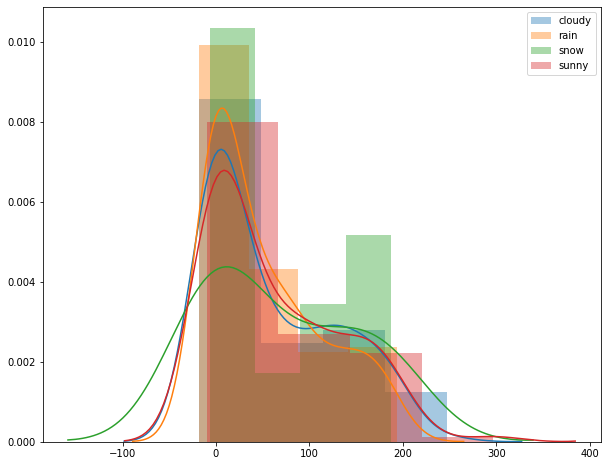

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

cloudy = (flights_weather[flights_weather['origin_weather']=='Cloudy']['dep_delay'].reset_index())
rain = (flights_weather[flights_weather['origin_weather']=='Rain']['dep_delay'].reset_index())
snow = (flights_weather[flights_weather['origin_weather']=='Snow']['dep_delay'].reset_index())
sunny = (flights_weather[flights_weather['origin_weather']=='Sunny']['dep_delay'].reset_index())

bins = 4

sns.color_palette('autumn')
plt.figure(figsize=(10,8))
sns.distplot(cloudy,bins=bins,label='cloudy')
sns.distplot(rain,bins=bins,label='rain')
sns.distplot(snow,bins=bins,label='snow')
sns.distplot(sunny,bins=bins,label='sunny')
plt.legend()
plt.show()